In [34]:
# Standard library imports
import os
import random
import gc
import copy

# Third-party library imports
import numpy as np
import pandas as pd

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# einops library for tensor operations
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# Custom TINTO library imports
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

In [35]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [36]:
import torch

# Get CUDA version
cuda_version = torch.version.cuda
print(f"CUDA Version: {cuda_version}")

# Get cuDNN version
cudnn_version = torch.backends.cudnn.version()
print(f"cuDNN Version: {cudnn_version}")

# Get PyTorch version
pytorch_version = torch.__version__
print(f"PyTorch Version: {pytorch_version}")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use GPU.")
    
    # Get the name of the current GPU
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    
    # Create a random tensor and move it to GPU to verify
    x = torch.rand(5, 3)
    print(f"Is this tensor on GPU? {x.cuda().is_cuda}")
else:
    print("CUDA is not available. PyTorch will use CPU.")

# Additional check: is CUDA initialized?
print(f"Is CUDA initialized? {torch.cuda.is_initialized()}")

# Number of available GPUs
print(f"Number of available GPUs: {torch.cuda.device_count()}")

# Current device index
print(f"Current device index: {torch.cuda.current_device()}")


CUDA Version: 11.8
cuDNN Version: 90100
PyTorch Version: 2.6.0+cu118
CUDA is available. PyTorch can use GPU.
Current GPU: NVIDIA GeForce RTX 3080
Is this tensor on GPU? True
Is CUDA initialized? True
Number of available GPUs: 1
Current device index: 0


## DATASET

In [37]:
SEED = 64
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [38]:
# Create variable to store dataset name
dataset_name = 'boston'
results_path = f'./logs/Regression/{dataset_name}/CNN+MLP_Regression'

In [39]:
df = pd.read_csv(f"../../2_Data/Regression/{dataset_name}.csv")

In [40]:
df.shape

(506, 14)

In [41]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## LOAD AND PREPROCESS

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32):
    
    X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
    X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    ### X_train
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #Generate thet images
        image_model.fit_transform(X_train, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}'+"/model.pkl")
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/train',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)
    
    # Update image paths
    imgs["images"] = images_folder + "/train/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_train], axis=1)

    # Split data
    X_train = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_train = combined_dataset["values"]
        
    ### X_val
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/val'):
        #Generate thet images
        image_model.transform(X_val, f'{images_folder}/val')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/val',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/val/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_val], axis=1)

    # Split data
    X_val = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_val = combined_dataset["values"]
    
    ### X_test
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/test'):
        #Generate thet images
        image_model.transform(X_test, f'{images_folder}/test')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/test',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/test/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_test], axis=1)

    # Split data
    X_test = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_test = combined_dataset["values"]
    
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    ## Create a MinMaxScaler object
    scaler = MinMaxScaler()

    ## Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Normalize to [0, 1]
    X_train_img_tensor = X_train_img_tensor / 255.0
    X_val_img_tensor = X_val_img_tensor / 255.0
    X_test_img_tensor = X_test_img_tensor / 255.0

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 

## MODEL ARCHITECTURES

In [43]:
class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape):
        super(Model1, self).__init__()
        
        # MLP branch
        self.mlp_branch = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the size of the flattened CNN output
        cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)
        
        # Final MLP layers
        self.final_mlp = nn.Sequential(
            nn.Linear(16 + cnn_output_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        
    def forward(self, mlp_input, cnn_input):
        mlp_output = self.mlp_branch(mlp_input)
        cnn_output = self.cnn_branch(cnn_input)
        
        # Concatenate the outputs of CNN and MLP branches
        concat_output = torch.cat((mlp_output, cnn_output), dim=1)
        
        # Final MLP layers
        final_output = self.final_mlp(concat_output)
        
        return final_output

In [44]:
class Model2(nn.Module):
    def __init__(self, attributes, imgs_shape):
        super(Model2, self).__init__()
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # MLP branch
        self.mlp_branch = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(attributes, imgs_shape)
        
        # Dense layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def _get_flat_size(self, attributes, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_mlp_input = torch.zeros(1, attributes)
        dummy_cnn_input = torch.zeros(1, *imgs_shape)
        
        mlp_output = self.mlp_branch(dummy_mlp_input)
        cnn_output = self.cnn_branch(dummy_cnn_input)
        
        return cnn_output.size(1)
    
    def forward(self, mlp_input, img_input):
        # CNN branch
        cnn_output = self.cnn_branch(img_input)
        
        # MLP branch
        mlp_output = self.mlp_branch(mlp_input)

        # Combine CNN and MLP outputs
        merged = torch.cat((mlp_output, cnn_output), dim=1)
        
        # Final layers
        final_output = self.final_mlp(merged)
        return final_output

## COMPILE AND FIT

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os

def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=100, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    
    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0
    #early_stopping_counter = 0
    #early_stopping_patience = 20
    #warm_up_epochs = epochs*0.3

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, img_data, targets in train_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            #early_stopping_counter = 0
        #else:
            #if epoch > warm_up_epochs:
                #early_stopping_counter += 1
                #if early_stopping_counter >= early_stopping_patience:
                    #print(f"Early stopping triggered at epoch {epoch+1}")
                    #break

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save figures for this fold
    os.makedirs(f"models/Regression/{dataset_name}/CNN+MLP/{model_name}", exist_ok=True)
    plot_metric(history['train_loss'], history['val_loss'], 'Loss', dataset_name, model_name)
    plot_metric(history['train_mse'], history['val_mse'], 'MSE', dataset_name, model_name)
    plot_metric(history['train_rmse'], history['val_rmse'], 'RMSE', dataset_name, model_name)
    plot_learning_rate(history['learning_rate'], dataset_name, model_name)

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/CNN+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/CNN+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
            
    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/CNN+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }    

def plot_metric(train_metric, val_metric, metric_name, dataset_name, model_name):
    plt.figure()
    plt.plot(train_metric, label=f'Train {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'{metric_name} vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/CNN+MLP/{model_name}/{metric_name.lower()}_plot.png")
    plt.close()

def plot_learning_rate(learning_rates, dataset_name, model_name):
    plt.figure()
    plt.plot(learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Epoch')
    plt.savefig(f"models/Regression/{dataset_name}/CNN+MLP/{model_name}/learning_rate_plot.png")
    plt.close()

In [46]:
def safe_compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=64, epochs=100, min_lr=1e-3, max_lr=1 , device='cuda', weight_decay=1e-2):
    try:
        if model is None:
            print(f"Model {model_name} is None")
            return None
        else:
            # Compile and fit the model
            metrics = compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, epochs=epochs, min_lr=min_lr, max_lr=max_lr, device=device, weight_decay=weight_decay)
            return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None
    finally:
        # Clear CUDA cache and force garbage collection
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

In [47]:
import traceback

def try_create_model(model_class, attributes, imgs_shape):
    try:
        model = model_class(attributes, imgs_shape)
        
        # Test the model with a sample input
        num_input = torch.randn(1, attributes)
        img_input = torch.randn(1, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}: {str(e)}")
        traceback.print_exc()
        return None

In [48]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter

def run_lr_finder(model_class, attributes, imgs_shape, dataset_name, name, train_loader, val_loader, num_iter):
    
    class MyTrainDataLoaderIter(TrainDataLoaderIter):
        def inputs_labels_from_batch(self, batch_data):
            # Since the data we want to used are the first two values of
            # `batch_data`, we need to pack them in this format,
            *desired_data, label = batch_data   # desired_data: x, x_embds
            return desired_data, label

    class MyValDataLoaderIter(ValDataLoaderIter):
        def inputs_labels_from_batch(self, batch_data):
            *desired_data, label = batch_data
            return desired_data, label

    class ModelWrapper(nn.Module):
        def __init__(self, model):
            super(ModelWrapper, self).__init__()
            self.model = model

        def forward(self, data):
            # Unpack data to the format you need
            x, x_embds = data
            return self.model(x, x_embds)

    # Define the path where the plot will be saved
    save_dir = os.path.join(f"logs/Regression/{dataset_name}/CNN+MLP/{name}")
    save_path = os.path.join(save_dir, 'lr_finder_plot.png')

    # Check if the file already exists
    if not os.path.exists(save_path):
        # Create and train Model
        model = try_create_model(model_class, attributes, imgs_shape)
        
        if model is None:
            return None
        
        # Prepare wrapper for dataloader
        train_loader_wrapper = MyTrainDataLoaderIter(train_loader)
        val_loader_wrapper = MyValDataLoaderIter(val_loader)
        
        # Prepare wrapper for model
        model_wrapper = ModelWrapper(model)
        
        # Move model to device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model_wrapper = model_wrapper.to(device)
        
        optimizer = optim.AdamW(model_wrapper.parameters(), lr=1e-7, weight_decay=1e-2)
        criterion = nn.MSELoss()
        
        lr_finder = LRFinder(model_wrapper, optimizer, criterion, device=device)
        lr_finder.range_test(train_loader_wrapper, val_loader=val_loader_wrapper, end_lr=1, num_iter=num_iter, step_mode="exp")
        
        axis, lr = lr_finder.plot()
        
        # Create the directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Get the figure from the axis and save it
        fig = axis.figure
        fig.savefig(save_path)
        print(f"Plot saved to: {save_path}")
        
        # Close the figure to ensure it's saved properly
        plt.close(fig)
        
        lr_finder.reset()
        print(f"Suggested learning rate: {lr}")
        
        return lr
    else:
        print(f"LR finder plot already exists at {save_path}. Skipping LR finder process.")
        # Load and display the existing image
        img = plt.imread(save_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title("Learning Rate Finder Plot")
        plt.show()
        
        return None  # Or you could return a default learning rate here

# Usage example:
# lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, name, train_loader, val_loader)

## EXPERIMENTS

In [49]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
#image_model = REFINED(problem= problem_type,hcIterations=5)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_TINTO"

In [50]:
def calculate_iterations_per_epoch(dataset_size, batch_size):
    iterations = dataset_size // batch_size
    if dataset_size % batch_size != 0:
        iterations += 1
    return iterations

In [51]:
batch_size = 16

In [52]:
num_epochs = calculate_iterations_per_epoch(df.shape[0], batch_size)

In [53]:
num_epochs

32

### EXPERIMENT

In [54]:
#Select the model and the parameters
#problem_type = "supervised"
problem_type = "regression"

# Transformation methods
image_model = TINTO(problem=problem_type, blur=True, option='maximum', pixels=20, random_seed=SEED)
name = f"TINTO_blur_maximum"
# image_model = REFINED(problem=problem_type, random_seed=SEED, zoom=1, n_processors=8)
# name = f"REFINED"
# image_model = IGTD(problem=problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
# name = f"IGTD_fEuclidean_iEuclidean_abs"
# image_model = BarGraph(problem=problem_type, zoom=2)
# name = f"BarGraph_zoom2"
# image_model = DistanceMatrix(problem=problem_type, zoom=2)
# name = f"DistanceMatrix_zoom2"
# image_model = Combination(problem=problem_type, zoom=2)
# name = f"Combination_zoom2"
# image_model = SuperTML(problem=problem_type, pixels=pixel, font_size=30, feature_importance=True, random_seed=SEED)
# name = f"SuperTML-VF_FS30"
# image_model = FeatureWrap(problem = problem_type, bins=10)
# name = f"FeatureWrap_bins10"
# image_model = BIE(problem = problem_type)
# name = f"BIE"

#Define the dataset path and the folder where the images will be saved
results_folder = f"Results/Binary/CNN+MLP_Fusion/{dataset_name}_{name}"
images_folder = f"Synthetic_images/Binary/images_{dataset_name}_{name}"

In [55]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

Synthetic_images/Binary/images_boston_TINTO_blur_maximum/train\regression.csv
Synthetic_images/Binary/images_boston_TINTO_blur_maximum/val\regression.csv
Synthetic_images/Binary/images_boston_TINTO_blur_maximum/test\regression.csv
Images shape:  (3, 20, 20)
Attributes:  13


Successfully created and tested Model1


100%|██████████| 32/32 [00:00<00:00, 83.93it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.52E-03


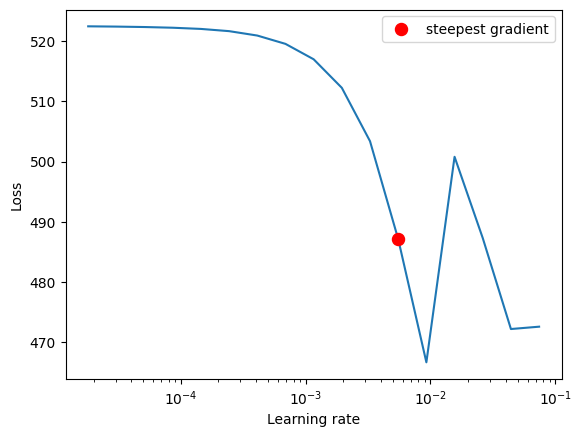

Plot saved to: logs/Regression/boston/CNN+MLP/TINTO_blur_maximum_Model1\lr_finder_plot.png
Suggested learning rate: 0.005519954321281566


In [56]:
lr = run_lr_finder(Model1, attributes, imgs_shape, dataset_name, f"{name}_Model1", train_loader, val_loader, num_iter=num_epochs)

In [57]:
# Create and train Model1
model1 = try_create_model(Model1, attributes, imgs_shape)  # Attempt to create Model1
model1_metrics = safe_compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-4, max_lr=7e-3)  # Train and evaluate Model1

Successfully created and tested Model1

Training completed in 9.75 seconds
Best model found at epoch 45/100
Best Train Loss: 15.3516, Best Val Loss: 13.5635
Best Train MSE: 15.6341, Best Val MSE: 16.4039
Best Train RMSE: 3.9540, Best Val RMSE: 4.0502
Best model saved to models/Regression/boston/CNN+MLP/TINTO_blur_maximum_Model1/best_model.pth


Successfully created and tested Model2


 88%|████████▊ | 28/32 [00:00<00:00, 73.27it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.56E-02


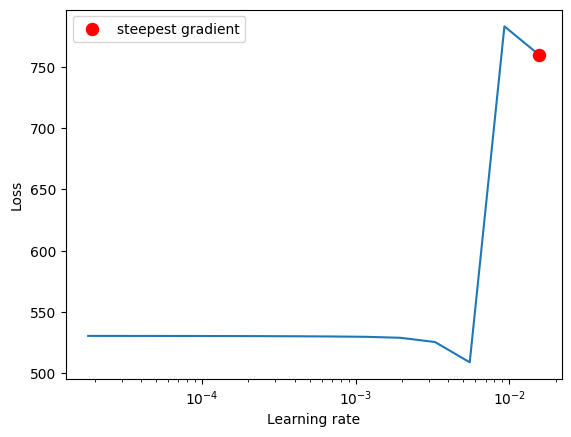

Plot saved to: logs/Regression/boston/CNN+MLP/TINTO_blur_maximum_Model2\lr_finder_plot.png
Suggested learning rate: 0.015615230060004972


In [58]:
lr = run_lr_finder(Model2, attributes, imgs_shape, dataset_name, f"{name}_Model2", train_loader, val_loader, num_iter=num_epochs)

In [59]:
# Create and train Model2
model2 = try_create_model(Model2, attributes, imgs_shape)  # Attempt to create Model2
model2_metrics = safe_compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-4, max_lr=4e-3)  # Train and evaluate Model2


Successfully created and tested Model2

Training completed in 11.62 seconds
Best model found at epoch 27/100
Best Train Loss: 18.5245, Best Val Loss: 12.0773
Best Train MSE: 18.0830, Best Val MSE: 14.6680
Best Train RMSE: 4.2524, Best Val RMSE: 3.8299
Best model saved to models/Regression/boston/CNN+MLP/TINTO_blur_maximum_Model2/best_model.pth


In [60]:
# Print comparison of metrics only for models that ran successfully
if model1_metrics:
    print("Model 1 Metrics:", model1_metrics)  # Print metrics for Model1 if available
if model2_metrics:
    print("Model 2 Metrics:", model2_metrics)  # Print metrics for Model2 if available

Model 1 Metrics: {'train_loss': 13.282960460736202, 'train_mse': 13.623809814453125, 'train_mae': 2.443786859512329, 'train_rmse': np.float64(3.6910445424639793), 'train_r2': 0.8380707502365112, 'val_loss': 13.563530683517456, 'val_mse': 16.403932571411133, 'val_mae': 2.957735061645508, 'val_rmse': np.float64(4.050176856806519), 'val_r2': 0.7290661334991455, 'test_loss': 17.180023670196533, 'test_mse': 20.42037010192871, 'test_mae': 2.6952712535858154, 'test_rmse': np.float64(4.518890361795549), 'test_r2': 0.8076494932174683, 'min_lr': 0.0001, 'max_lr': 0.007, 'total_time': 9.746222496032715, 'average_epoch_time': 0.09744216442108154}
Model 2 Metrics: {'train_loss': 14.860116857748766, 'train_mse': 15.168121337890625, 'train_mae': 2.621224880218506, 'train_rmse': np.float64(3.8946272399153457), 'train_r2': 0.8197153806686401, 'val_loss': 12.07732492685318, 'val_mse': 14.668034553527832, 'val_mae': 2.750459909439087, 'val_rmse': np.float64(3.8298870157653258), 'val_r2': 0.75773692131042

## FINAL METRICS AND BEST MODEL

In [ ]:
def find_best_model(base_path):
    best_rmse = float('inf')
    best_folder = None

    # Walk through all directories and files in the base path
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == f'metrics.txt':
                file_path = os.path.join(root, file)
                
                # Read metrics from the file
                with open(file_path, 'r') as f:
                    metrics = f.read()
                
                # Parse the metrics into a dictionary
                metrics_dict = {}
                for line in metrics.splitlines():
                    key, value = line.split(': ')
                    metrics_dict[key.strip()] = float(value.strip())
                
                # Check if the current folder has a better validation loss
                if metrics_dict['test_rmse'] < best_rmse:
                    best_rmse = metrics_dict['test_rmse']
                    best_folder = root
    
    return best_folder, best_rmse

In [ ]:
import os

def read_metrics(file_path):
    metrics = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.split(': ')
            metrics[key.strip()] = float(value.strip())
    return metrics

def rename_folder(old_folder_path, prefix):
    folder_name = os.path.basename(old_folder_path)
    new_folder_name = f"{prefix}_{folder_name}"
    parent_dir = os.path.dirname(old_folder_path)
    new_folder_path = os.path.join(parent_dir, new_folder_name)
    os.rename(old_folder_path, new_folder_path)
    return new_folder_path

def process_folders(root_dir):
    prefixes = ["TINTO", "BarGraph", "Combination", "DistanceMatrix", "IGTD", "REFINED", "SuperTML", "FeatureWrap", "BIE"]
    best_folders = []

    for prefix in prefixes:
        matching_folders = [f for f in os.listdir(root_dir) if f.startswith(prefix) and os.path.isdir(os.path.join(root_dir, f))]
        if matching_folders:
            best_folder = None
            best_test_rmse = float('inf')
            for folder in matching_folders:
                metrics_file = os.path.join(root_dir, folder, 'metrics.txt')
                if os.path.exists(metrics_file):
                    metrics = read_metrics(metrics_file)
                    if metrics['test_rmse'] < best_test_rmse:
                        best_test_rmse = metrics['test_rmse']
                        best_folder = folder
            if best_folder:
                new_path = rename_folder(os.path.join(root_dir, best_folder), "TOP")
                best_folders.append(new_path)
    
    if best_folders:
        overall_best_folder = None
        overall_best_test_rmse = float('inf')
        for folder in best_folders:
            metrics_file = os.path.join(folder, 'metrics.txt')
            if os.path.exists(metrics_file):
                metrics = read_metrics(metrics_file)
                if metrics['test_rmse'] < overall_best_test_rmse:
                    overall_best_test_rmse = metrics['test_rmse']
                    overall_best_folder = folder
        if overall_best_folder:
            rename_folder(overall_best_folder, "BEST")
        
    return best_folders

In [ ]:
# Usage
base_path = f"logs/Regression/{dataset_name}/CNN+MLP"
best_folders = process_folders(base_path)
print(f"Best model folder: {best_folders}")